## Crosscheck of Josh's code and the m3 results
In this notebook, we'll take a m3 simulation file, run it through the code, and see how they compare. I have made four changes to this file compared to the original Josh F sent:
1. I use a SNR of 3. This matches what was used for the m3 result
2. I have added a reference impedance term to the voltage rescaling. This is because the method for evaluating voltage in COMSOL for m3 was different and requires this term. It also matches the procedue outlined in the m3 paper
3. I use a constant Q of 2e4. The m3 uses a Q that is a function of frequency, at the 180-200 MHz regime, their Q is similar to 2e4, so that gave the closest comparison
4. I have added a plot at the end showing how Josh's results compare to the m3 values when multiplied by a factor of 4pi^2

In [1]:
import numpy as np
from astropy import units, constants
from astropy.units import def_unit
import linecache

from scipy import stats
from scipy.interpolate import CubicSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.style.use('../rodd_style.mplstyle')

# Defining our 95% exclusion threshold
# snr_target = stats.chi2.ppf(.9, df = 1)**.5
snr_target = 3 # This is what was used for m3

In [2]:
# Mass-coupling relation
KSVZ = 1.92
DFSZ = 0.75

def g_x(C_ag,m_a):
    return 2e-10*C_ag*m_a

# Let's define our units

- Impedances – $\Omega$  
- Inductance – H
- Voltage - V
- Frequency – MHz  
- Temperature – mK
- Magnetic Field - Tesla

In [3]:
planck_h = constants.h.to(units.eV/units.MHz).value
boltzmann_k = constants.k_B.to(units.eV/units.mK).value

# Some useful unit conversions from GUTCalc
voltage_to_eV = 3.30227
henry_to_inveV = 4.03278e+12

# A/m^2 * GeV / T
external_current_units = 10.6049

In [4]:
rescale_factor = 1

In [5]:
1/external_current_units

0.09429603296589312

In [6]:
# Loading the data
# voltage_data = np.loadtxt('/home/aenge/cal_sensitivity/comsol_sims_josh/source_voltage.txt', skiprows = 5).T
# source_impedance_data = np.loadtxt('/home/aenge/cal_sensitivity/comsol_sims_josh/source_impedance.txt', skiprows = 5).T

# impedance_file = '/home/aenge/cal_sensitivity/comsol_sims_parametric_test/Imp_3D_Param2_12_8'
# voltage_file = '/home/aenge/cal_sensitivity/comsol_sims_parametric_test/Volt_3D_Param2_12_8'

impedance_file = '/home/aenge/cal_sensitivity/comsol_sims_nick/Zw_04scale_Feb2024.txt'
voltage_file = '/home/aenge/cal_sensitivity/comsol_sims_nick/Vw_04scale_Feb2024.txt'

sim_impedances = np.loadtxt(impedance_file, skiprows = 5).T
sim_voltages = np.loadtxt(voltage_file, skiprows = 5).T

frequencies = np.around(sim_voltages[-2], decimals=2)
impedance_list = sim_impedances[-2] + 1j*sim_impedances[-1]
# voltage_list =  g_x(1e-9*freq_to_ev(freqs)) * np.abs((impedance_list + Z_Ref) / Z_Ref) * sim_voltages[-1] * external_current_units
voltage_list = sim_voltages[-1]

# x = sim_impedances[:num_params]

# indexes = [index for index, _ in enumerate(x[0]) if any(x[:,index] != x[:,index-1])]
# indexes.append(len(x[0]))

# freqs = np.around(sim_voltages[-2], decimals=2)[indexes[0]:indexes[1]]
# voltage_list = [sim_voltages[-1][indexes[i]:indexes[i+1]] for i, _ in enumerate(indexes) if i != len(indexes)-1]
# impedance_list = [sim_impedances[-2][indexes[i]:indexes[i+1]] + 1j*sim_impedances[-1][indexes[i]:indexes[i+1]] for i, _ in enumerate(indexes) if i != len(indexes)-1]
# param_vals = [sim_impedances[:-3,i] for i in indexes[:-1]]

# for i, volt_list in enumerate(voltage_list):
#     # voltage_list[i] = 9*g_x(freq_to_ev(freqs)) * np.abs((impedance_list[i] + Z_Ref) / Z_Ref) * volt_list / (0.0942964)
#     voltage_list[i] = volt_list

# names_and_units = linecache.getline(voltage_file, 5).split()[1:-4]
# opt_params = [names_and_units[i] for i,_ in enumerate(names_and_units) if names_and_units[i][0] != '(']
# # opt_params = [f'{names_and_units[i]} {names_and_units[i+1]}' for i, _ in enumerate(names_and_units) if i %2 == 0]


source_reactance = np.imag(impedance_list)
source_voltage = voltage_list
# source_voltage = voltage_list[0]
# source_impedance_data = np.load('../Shielded_Solenoid/chiara_390mmdiam_wish/source_impedance.npy')
# voltage_data = np.load('../Shielded_Solenoid/chiara_390mmdiam_wish/source_voltage.npy')


#source_impedance_data = np.load('../Shielded_Solenoid/dmradiom3_fid/source_impedance.npy')
#voltage_data = np.load('../Shielded_Solenoid/dmradiom3_fid/source_voltage.npy')

# frequencies = 1e3*source_impedance_data[0] / rescale_factor
# source_reactance = source_impedance_data[2] * rescale_factor# Sim was lossless.
# source_voltage = rescale_factor**2 * np.abs(voltage_data[1]+1j*voltage_data[2]) # Don't care about phase

locs =np.where(frequencies<=np.inf)
frequencies = frequencies[locs]
source_reactance = source_reactance[locs]
source_voltage = source_voltage[locs]

# Defining the splines
get_source_voltage = CubicSpline(frequencies, source_voltage)
get_source_reactance = CubicSpline(frequencies, source_reactance)
get_source_reactance_derivative = get_source_reactance.derivative()

In [7]:
def get_Leff(freq):
    """
    Compute the effective inductance L_eff at a given frequency.
    This implements Eq. (6) from arXiv:2302.14084:
        L_eff(f) = [Z_s(f) + f * dZ_s/df] / (4π f)
    """
    
    # Compute numerator: freq * dZs/df + Zs, all in Ohms
    numerator = freq * get_source_reactance_derivative(freq)+ get_source_reactance(freq)
    denominator = 4 * np.pi * (1e6*freq)

    return (numerator / denominator)

(1e-18, 1e-08)

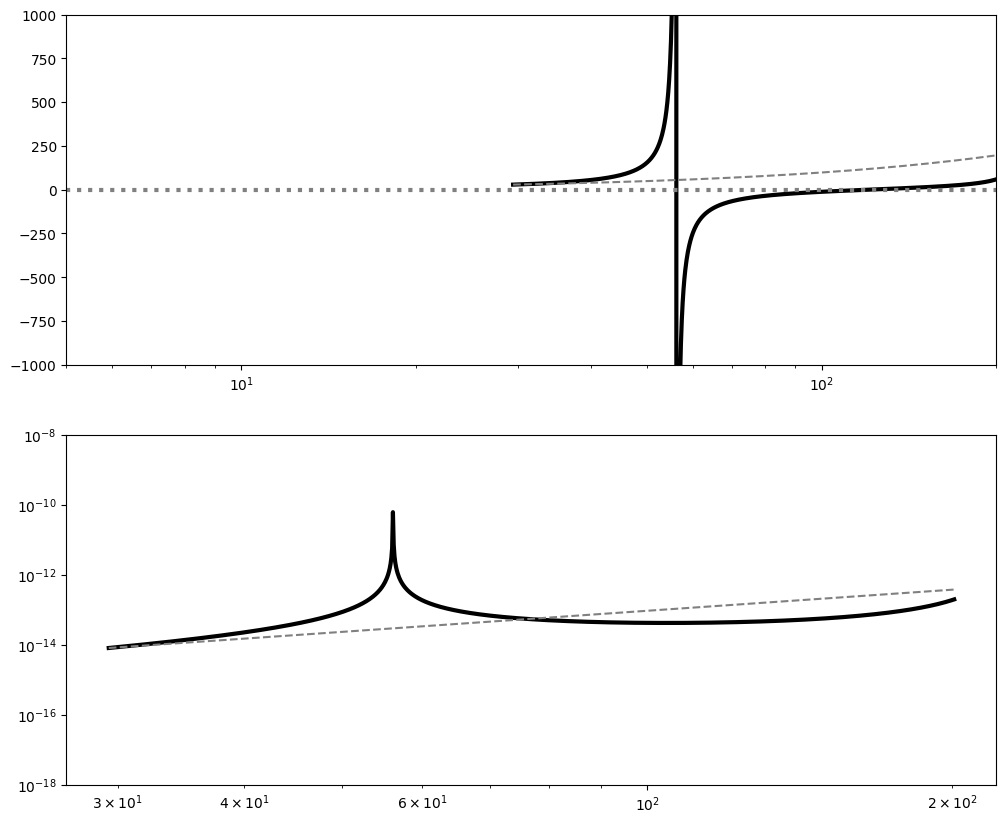

In [8]:
fig, axs = plt.subplots(nrows = 2, figsize = (12,10))

axs[0].plot(frequencies,  source_reactance,color = 'black', lw= 3)
axs[0].plot(frequencies,  source_reactance[0] * frequencies/ frequencies[0],color = 'grey', ls='--')
axs[0].set_ylim(-1e3, 1e3)
axs[0].set_xlim(5,200)

dfsz_coupling = g_x(DFSZ, 2*np.pi * 6.58212e-10 * frequencies)
axs[1].plot(frequencies, 10*source_voltage  * dfsz_coupling, color = 'black', lw =3)
axs[1].plot(frequencies, 10*source_voltage[0] * (frequencies/frequencies[0])*dfsz_coupling, color = 'grey', ls = '--')
axs[1].set_yscale('log')
axs[0].set_xlim(5,200)

axs[0].axhline(0, color= 'grey', lw = 3, ls = ':')
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[1].set_ylim(1e-18,1e-8)

# Scan Rate Calculation

In [9]:
def get_GBar(nu_r, T, eta_A=20):
    
    # --- Compute thermal photon occupation number n_T ---
    exponent = (planck_h * nu_r) / (boltzmann_k * T)
    n_T = 1 / (np.exp(exponent) - 1)

    # --- Compute alpha_bar (Eq. 13) ---
    two_nT_plus_1 = 2 * n_T + 1
    alpha_bar = (2 * eta_A**2) / (two_nT_plus_1 + np.sqrt(two_nT_plus_1**2 + 8 * eta_A**2))

    # --- Compute Ḡ (Eq. 12) ---
    denom = (alpha_bar**2 + 2 * two_nT_plus_1 * alpha_bar + eta_A**2)**(3 / 2)
    GBar = alpha_bar / denom

    return GBar

In [10]:
def dnu_dt(nu_r, Q=2e5, T=20, C_ag = KSVZ, B = 5):
    
    Z_Ref = 50e9

    ma_nat = constants.h.to('eV/MHz').value * nu_r # [eV]
    prefactor = 6.4e5*np.pi / snr_target**2 / 16 / ma_nat**4 # [1/eV^4]

    GBar = get_GBar(nu_r, T) # unitless
    Leff = get_Leff(nu_r)*henry_to_inveV # [1/eV]

    # The voltage was computed using an external current density with |J| = 1 A / m^2 so now
    # now we need to convert this to the appropriate current density for our axion scenario
    g_agg = g_x(C_ag, ma_nat) # GeV^(-1)
    # voltage_rescaling = external_current_units * g_agg * B # A / m^2
    voltage_rescaling = external_current_units * g_agg * B * np.abs((impedance_list + Z_Ref) / Z_Ref) # Need to add ref impedance for m3 voltages
    V = voltage_rescaling * get_source_voltage(nu_r) * voltage_to_eV # [eV]
    print(nu_r[0],prefactor[0], V[0], Leff[0], Q, GBar[0])
    
    
    scan_rate = prefactor * V**4 * Q * GBar  / Leff**2 # [eV^2]
    scan_rate /= constants.h.to('eV/MHz').value # [eV-Hz]
    scan_rate /= constants.h.to(units.eV * units.yr).value    
    
    return scan_rate

In [11]:
import pandas as pd
m3_rates = pd.read_csv('/home/aenge/cal_sensitivity/comsol_sims_nick/m3ScanRates--variableEta--Winter2024 - v04_nt_1MHz.csv', header = 1)
m3_rates

,f,SR [Hz/s],R,dR/df,L,C,Ltuning,Ctuning,Q,Q*6
0,30.0,0.000629,0.00281,1.720000e-10,2.130000e-07,5.160000e-10,0.0,1.780000e-10,14300.0,85800.0
1,31.0,0.000763,0.00299,1.910000e-10,2.240000e-07,4.290000e-10,0.0,1.630000e-10,14600.0,87600.0
2,32.0,0.000922,0.00319,2.130000e-10,2.360000e-07,3.560000e-10,0.0,1.490000e-10,14900.0,89400.0
3,33.0,0.001110,0.00341,2.390000e-10,2.490000e-07,2.960000e-10,0.0,1.360000e-10,15200.0,91200.0
4,34.0,0.001330,0.00366,2.700000e-10,2.650000e-07,2.460000e-10,0.0,1.250000e-10,15400.0,92400.0
...,...,...,...,...,...,...,...,...,...,...
166,196.0,0.284000,0.00878,5.520000e-10,1.610000e-07,5.530000e-12,0.0,1.580000e-11,22600.0,136000.0
167,197.0,0.290000,0.00936,6.140000e-10,1.710000e-07,5.100000e-12,0.0,1.520000e-11,22600.0,136000.0
168,198.0,0.297000,0.01000,6.860000e-10,1.820000e-07,4.690000e-12,0.0,1.460000e-11,22600.0,136000.0
169,199.0,0.304000,0.01070,7.700000e-10,1.950000e-07,4.290000e-12,0.0,1.400000e-11,22700.0,136000.0


29.4 6.388449853798637e+31 2.8148354869435453e-14 834158.6415229356 20000.0 0.0002883506860176949


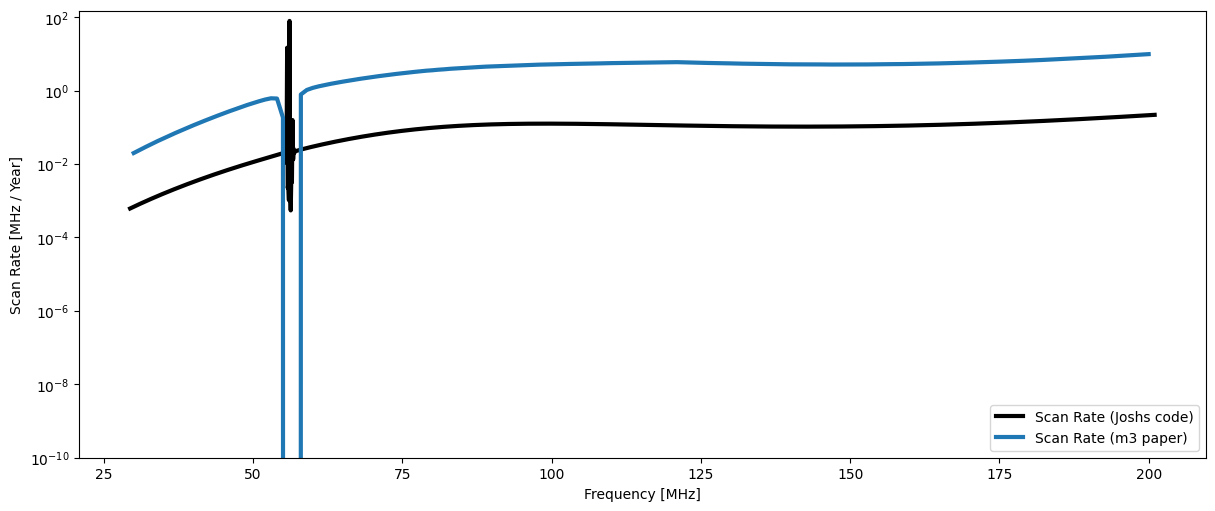

In [12]:
fig, axs = plt.subplots(figsize = (12, 5))

match_x= frequencies[0]
# match_y = np.interp(match_x,frequencies, dnu_dt(frequencies, Q = 2e4, B = 1, C_ag = DFSZ))

plt.plot(frequencies, dnu_dt(frequencies, Q = 2e4, B = 1, C_ag = DFSZ), color = 'black', lw = 3, label = 'Scan Rate (Joshs code)')
plt.plot(m3_rates['f'], m3_rates['SR [Hz/s]']*86400*365.25*1e-6, lw = 3, label = 'Scan Rate (m3 paper)')
#plt.plot(frequencies, dnu_dt(frequencies, Q = 1e6, B = 10, C_ag = KSVZ), color = 'black', lw = 3,ls = '--')
# plt.plot(frequencies, dnu_dt(frequencies, Q = 1e4, B = 9, C_ag = 100*KSVZ), color = 'black', lw = 3,ls = '--')
#plt.xlim(frequencies[0], frequencies[-1])
plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()
#plt.axvspan(10, 58)
plt.ylim(1e-10, None)
#plt.ylim(1e-4, 1e2)
plt.xlabel('Frequency [MHz]')
plt.ylabel("Scan Rate [MHz / Year]")
plt.legend()
# plt.savefig('./WithWrongScaling.png')

29.4 6.388449853798637e+31 2.8148354869435453e-14 834158.6415229356 20000.0 0.0002883506860176949


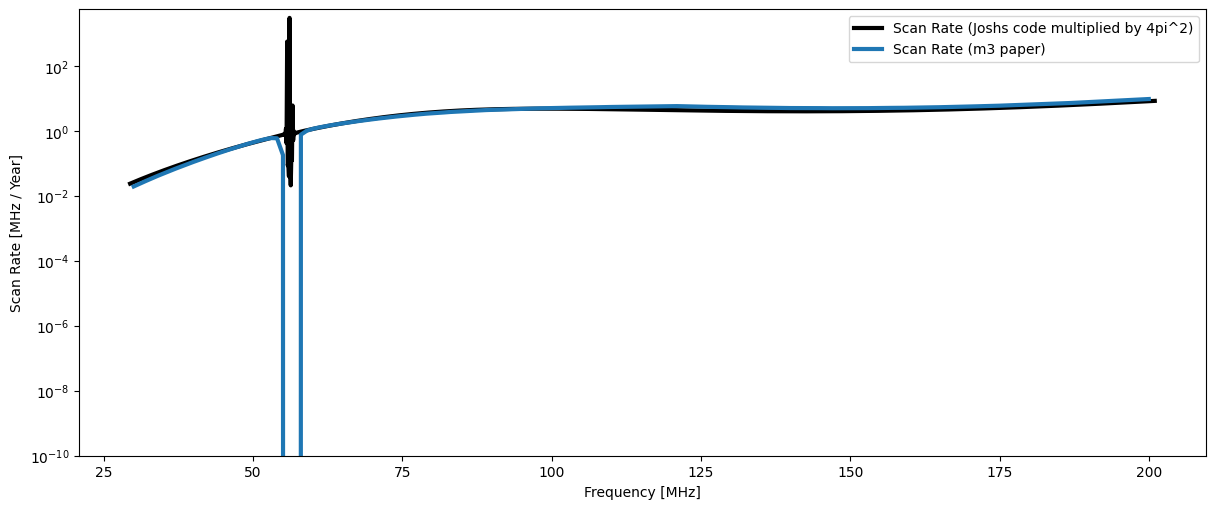

In [14]:
fig, axs = plt.subplots(figsize = (12, 5))

match_x= frequencies[0]
# match_y = np.interp(match_x,frequencies, dnu_dt(frequencies, Q = 2e4, B = 1, C_ag = DFSZ))

plt.plot(frequencies, 4*np.pi**2*dnu_dt(frequencies, Q = 2e4, B = 1, C_ag = DFSZ), color = 'black', lw = 3, label = 'Scan Rate (Joshs code multiplied by 4pi^2)')
plt.plot(m3_rates['f'], m3_rates['SR [Hz/s]']*86400*365.25*1e-6, lw = 3, label = 'Scan Rate (m3 paper)')
#plt.plot(frequencies, dnu_dt(frequencies, Q = 1e6, B = 10, C_ag = KSVZ), color = 'black', lw = 3,ls = '--')
# plt.plot(frequencies, dnu_dt(frequencies, Q = 1e4, B = 9, C_ag = 100*KSVZ), color = 'black', lw = 3,ls = '--')
#plt.xlim(frequencies[0], frequencies[-1])
plt.yscale('log')
# plt.xscale('log')
plt.tight_layout()
#plt.axvspan(10, 58)
plt.ylim(1e-10, None)
#plt.ylim(1e-4, 1e2)
plt.xlabel('Frequency [MHz]')
plt.ylabel("Scan Rate [MHz / Year]")
plt.legend()
# plt.savefig('./WithWrongScaling.png')